In [28]:
#module LqrHoverController
    using TOML
    using ZMQ
    using ProtoBuf
    using LinearAlgebra
    using ForwardDiff
    using BlockDiagonals
    using ControlSystems
    using PyPlot 
    using SparseArrays
    using OSQP

In [29]:
function hat(v) #skew symmetric matrix operator
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q) #the function takes a quaternion as input
    s = q[1] #scalar part of quaternion
    v = q[2:4] #vector part of quaternion
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end

T = Diagonal([1; -ones(3)]) # to find the inverse of a quaternion
H_ = [zeros(1,3); I]  #zero the scalar part of quaternion
function qtoQ(q) #figure out what this function is for

    return H_'*T*L(q)*T*L(q)*H_
end

function G(q)
    G = L(q)*H_
end

function rptoq(phi)# mapping between rodrigues parameter and quaternion
    (1/sqrt(1+phi'*phi))*[1; phi] #known as the Cayley map
end
function qtorp(q) #mapping between quaternion to rodrigues parameter
    q[2:4]/q[1]
end

# updated quadrotor parameters
m = 1.776 # in kg
l = 0.28 #in m
J = [0.01566089 0.00000318037 0; 0.00000318037 0.01562078 0; 0 0 0.02226868]
g = 9.81
kt=0.11
km=0.044

umin = [0;0;0;0]
umax = [0.6*m*g;0.6*m*g;0.6*m*g;0.6*m*g]

h = 0.05 #20 Hz

Nx = 13     #number of states (w quaternion)
Nx_ = 12    #number of states (linearized using rodrigues parameters)
Nu = 4     # number of controls
Tfinal = 5.0 #final time (may change if it is not discrete time)
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));


In [30]:
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

function quad_dynamics(x,u)
    #print("in the dynamics function")
    r = x[1:3]
    #print(r)
    q = x[4:7]
    #print(q)
    v = x[8:10]
    #print(v)
    omega = x[11:13]
    #print(omega)
    #print(size(q))
    Q = qtoQ(q)
    #print("passed the dynamics function")
    
    rdot = Q*v
    qdot = 0.5*L(q)*H_*omega
    
    vdot = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(omega)*v
    
    omegadot = J\(-hat(omega)*J*omega + [0 l*kt 0 -l*kt; -l*kt 0 l*kt 0; km -km km -km]*u)
    
    return [rdot; qdot; vdot; omegadot]
end

function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    #print("IN THE RK4 DYNAMICS")
    f1 = quad_dynamics(x, u)
    #print("passed quad dyanamics")
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion to reduce error
    return xn #returns the state at a future timestep
end

quad_dynamics_rk4 (generic function with 1 method)

In [31]:
#Initial Conditions
uhover = (m*g/4)*ones(4) #gravity compensation for a hover
r0 = [0.0; 0; 1.0] #1 meter off the ground
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
omega0 = zeros(3) #stable hover, no velocities
x0 = [r0; q0; v0; omega0]; #initial/reference state

#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);

#reduced system to make it controllable 
A_ = Array(E(q0)'*A*E(q0));
B_ = Array(E(q0)'*B);

#cost weights
Q = Array(1.0*I(Nx_));
R = Array(0.1*I(Nu));
Qn = Array(1.0*I(Nx_));

K = dlqr(A_,B_,Q,R)
P_ = dare(A_,B_,Q,R)


12×12 Matrix{Float64}:
 31.4833        -0.00034497    2.11251e-13  …   2.32573      -4.01876e-14
 -0.00034497    31.4877       -3.68185e-14     -0.000451107  -5.62602e-15
 -2.92289e-14   -3.47328e-13  49.9227          -3.34805e-15   1.84816e-13
  0.00436802   -58.7229        4.41843e-13      0.00709048    5.89423e-14
 58.6678        -0.00436802    2.42644e-12     30.3313       -2.24106e-13
 -2.50096e-14    2.41945e-13  -1.27836e-12  …  -1.56881e-14   1.67673
 13.9929        -0.000534453   3.18057e-13      3.6021       -3.50172e-14
 -0.000534453   13.9997       -5.67735e-14     -0.000739     -1.09409e-14
 -1.18573e-13   -1.409e-12    51.0589          -1.36264e-14   4.97988e-13
  0.000451107   -2.33142       2.04857e-14      0.000994128   2.94598e-15
  2.32573       -0.000451107   1.08437e-13  …   4.24158      -1.06222e-14
 -2.82879e-14    8.82805e-14  -6.48801e-14     -9.57436e-15   2.24573

In [32]:
#Build QP matrices for OSQP
Nh = 20
Nx_ = 12
Nu = 4
U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx_)]) #Matrix that picks out all u
Θ = kron(Diagonal(I,Nh), [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 ]) #Matrix that picks out all x3 (θ)
H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx_); zeros(Nx_,Nu) Q]) zeros((Nx_+Nu)*(Nh-1), Nx_+Nu); zeros(Nx_+Nu,(Nx_+Nu)*(Nh-1)) [R zeros(Nu,Nx_); zeros(Nx_,Nu) P_]])
b = zeros(Nh*(Nx_+Nu))
C = sparse([[B_ -I zeros(Nx_,(Nh-1)*(Nu+Nx_))]; zeros(Nx_*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A_ B_]) zeros((Nh-1)*Nx_,Nx_)] + [zeros((Nh-1)*Nx_,Nx_) kron(Diagonal(I,Nh-1),[zeros(Nx_,Nu) Diagonal(-I,Nx_)])]])
print(size(U))
print(size(C))
print(size(Θ))
#D = [C; U]
#lb = [zeros(Nx_*Nh); kron(ones(Nh),umin-uhover)]
#ub = [zeros(Nx_*Nh); kron(ones(Nh),umax-uhover)]
D = [C; U; Θ]
lb = [zeros(Nx_*Nh); kron(ones(Nh),umin-uhover); -0.3*ones(Nh)]
ub = [zeros(Nx_*Nh); kron(ones(Nh),umax-uhover); 0.3*ones(Nh)]

#print(size(lb))

prob = OSQP.Model()
OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

(80, 320)(240, 320)(20, 320)

In [33]:
#MPC Controller
function mpc_controller(t,x,xref)
    
    q0 = x0[4:7]
    q = x[4:7]
    phi = qtorp(q)
    
    x_ = [x[1:3]; phi; x[8:10]; x[11:13]]
    
    #print(size(x_))
    #print(size(A_))
    #print("the error is here")
    #Update QP problem
    lb[1:12] .= -A_*(x_-xref)
    ub[1:12] .= -A_*(x_-xref)
    
    #print("ERROR")
    
    for j = 1:(Nh-1)
        
        b[(Nu+(j-1)*(Nx_+Nu)).+(1:Nx_)] .= -Q*xref
    end
    #print("finished")
    b[(Nu+(Nh-1)*(Nx_+Nu)).+(1:Nx_)] .= -P_*xref
    #print("error here")
    OSQP.update!(prob, q=b, l=lb, u=ub)
    #print("error updating")
    #print("updated QP")

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]
    print("return control action")

    return uhover + Δu
end

mpc_controller (generic function with 1 method)

In [34]:
function closed_loop(x0,controller,N)
    print("in the closed loop")
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    #xhist[:,1] .= x0
    xhist[:,1] .= [r0+[2;2;1]; L(q0)*rptoq([0.414; 1; 1.59]); v0; omega0]
    #print("this is xhist")
    #print( xhist[:,1])
    #print("this is uhist")
    #print(uhist[:,1])
    #print("uhist initialized")
    for k = 1:(N-1)
        print("in the for loop")
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        print("this is xhist")
        print(size(xhist[:,1]))
        print("this is uhist")
        print(size(uhist[:,1]))
        print("about to send dynamics")
        xhist[:,k+1] .= quad_dynamics_rk4(xhist[:,k],uhist[:,k])
        print("in here")
    end
    print("returning pose")
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [35]:
#q0 = x0[4:7]
#q = x[4:7]
#phi = qtorp(L(q0)'*q)

x_start = [r0+[2;2;1]; L(q0)*rptoq([0.414; 1; 1.59]); v0; omega0]

#print(size(x_start))

x_ref = [r0; qtorp(q0);v0; omega0]

#print(size(x_ref))

#x0 = [r0+[2;2;1]; L(q0)*rptoq([0.414; 1; 1.59]); v0; omega0]

xhist2, uhist2 = closed_loop(x_start, (t,x)->mpc_controller(t,x,x_ref), Nt);


in the closed loopreturn control actionin the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is uhist(4,)about to send dynamicsin herein the for loopreturn control actionthis is xhist(13,)this is

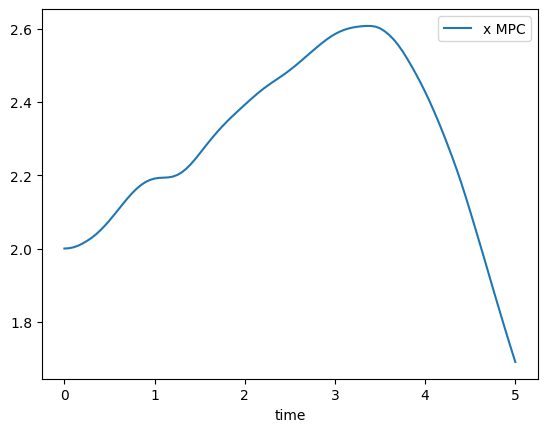

PyObject <matplotlib.legend.Legend object at 0x7f1a88f60850>

In [36]:
plot(thist,xhist2[1,:], label="x MPC")
xlabel("time")
legend()

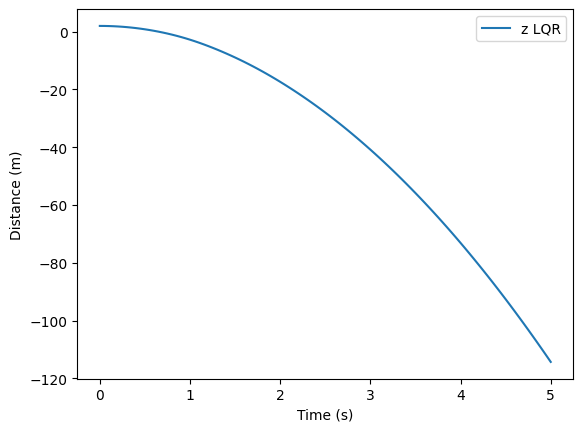

In [37]:
plot(thist,xhist2[3,:], label="z LQR")
xlabel("Time (s)")
ylabel("Distance (m)")
legend()
show()

In [15]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/fausto/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [16]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [17]:
X1 = [SVector{13}(x) for x in eachcol(xhist2)];
visualize!(vis, model, thist[end], X1)